In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from torch.autograd import Variable
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Data preparation

As a training sample, let's take the [Flickr Faces](https://github.com/NVlabs/ffhq-dataset) dataset, which contains images of people's faces in high resolution (1024 x 1024). Let's replace the size of the images to the value 128, because the size 1024 is too large.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/DL/archive.zip -d faces_dataset
!rm -r faces_dataset/__MACOSX
!rm -r faces_dataset/faces_dataset_small/04000
!mv faces_dataset/faces_dataset_small faces_dataset/images

rm: cannot remove 'faces_dataset/__MACOSX': No such file or directory
rm: cannot remove 'faces_dataset/faces_dataset_small/04000': No such file or directory
mv: cannot stat 'faces_dataset/faces_dataset_small': No such file or directory


In [ ]:
from pathlib import Path
DATA_DIR = Path('./faces_dataset')

In [ ]:
def get_dataloader(image_size, batch_size):
  
  train_ds = ImageFolder(DATA_DIR, transform = tt.Compose([
      tt.Resize(image_size),
      tt.CenterCrop(image_size),
      tt.ToTensor(),
      tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

  return train_dl

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
image_size = 128
batch_size = 128
train_dl = get_dataloader(image_size, batch_size)

In [ ]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 3, 128, 128])
torch.Size([128])


In [ ]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

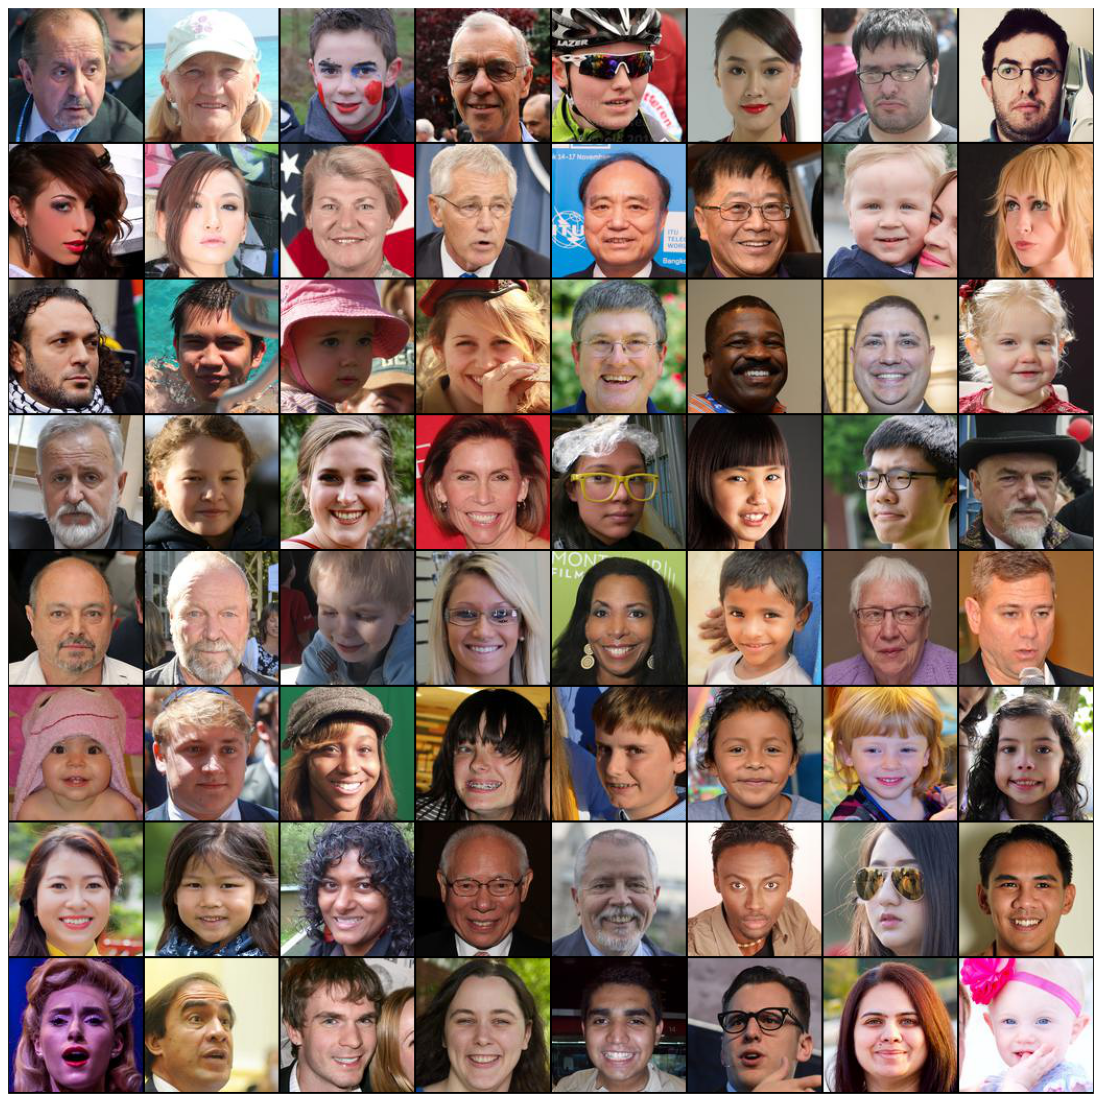

In [ ]:
show_batch(train_dl)

## Building and training a model

Построим генератор и дискриминатор.

Дискриминатор принимает на вход изображение (тензор размера 3 x image_size x image_size) и выдает вероятность того, что изображение настоящее (тензор размера 1).

Генератор принимает на вход тензор шумов размера latent_size x 1 x 1 и генерирует изображение размера 3 x image_size x image_size.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # in: 3 x 128 x 128

            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 32 x 32
            
            nn.Conv2d(128, 256, kernel_size=4, stride=4, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8
            
            nn.Conv2d(256, 512, kernel_size=8, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 1 x 1

            nn.Flatten(),
            nn.Linear(512, 512),
            nn.Linear(512, 1),
            nn.Sigmoid()
            )
        
    def forward(self, input):
        return self.main(input)

In [ ]:
latent_size = 128
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # in: latent_size x 1 x 1

            nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # out: 512 x 4 x 4
            
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 8 x 8
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 16 x 16
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 32 x 32
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 64 x 64
            
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 128 x 128
            )
        
    def forward(self, input):
        return self.main(input)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
ngpu = 1

Discr = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    Discr = nn.DataParallel(Discr, list(range(ngpu)))
    
Discr.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(4, 4), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_feature

In [ ]:
ngpu = 1

Gener = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    Gener = nn.DataParallel(Gener, list(range(ngpu)))
    
Gener.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

Let's count the number of parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model discriminator has {count_parameters(Discr):,} trainable parameters')
print(f'The model generator has {count_parameters(Gener):,} trainable parameters')

The model discriminator has 2,298,241 trainable parameters
The model generator has 13,245,312 trainable parameters


Now let's move on to the training of our GAN.

In [ ]:
def GaussianNoise(x, std):
    return x + torch.empty_like(x).normal_(std)

In [ ]:
lr_g = 0.0002
lr_d = 0.0002
beta1 = 0.5
epochs = 5

# Create criterion
criterion = {
        "discriminator": nn.BCELoss(),
        "generator": nn.BCELoss()
}

In [ ]:
def fit(D, G, criterion, epochs, lr_g, lr_d, beta1, start_idx=1):
    D.train()
    G.train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores_1 = []
    fake_scores_2 = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(D.parameters(), lr=lr_d, betas=(beta1, 0.999)),
        "generator": torch.optim.Adam(G.parameters(), lr=lr_g, betas=(beta1, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch_1 = []
        fake_score_per_epoch_2 = []

        for real_images, _ in tqdm(train_dl):
            real_images = GaussianNoise(real_images, 0.1)
            real_images = real_images.to(device)

            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = D(real_images).view(-1)
            real_targets = torch.ones(real_images.size(0), device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            real_loss.backward()
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = G(latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), device=device)
            fake_preds = D(fake_images.detach()).view(-1)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            fake_loss.backward()
            cur_fake_score_1 = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch_1.append(cur_fake_score_1)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            # Train generator
            # Clear generator gradients

            optimizer["generator"].zero_grad()
            
            # Try to fool the discriminator
            preds = D(fake_images).view(-1)
            cur_fake_score_2 = torch.mean(preds).item()
            targets = torch.ones(batch_size, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            fake_score_per_epoch_2.append(cur_fake_score_2)

            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores_1.append(np.mean(fake_score_per_epoch_1))
        fake_scores_2.append(np.mean(fake_score_per_epoch_2))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score_1: {:.4f}, fake_score_2: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores_1[-1], fake_scores_2[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores_1, fake_scores_2

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
history = fit(Discr, Gener, criterion, epochs, lr_g, lr_d, beta1)

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [1/3], loss_g: 2.6623, loss_d: 0.7417, real_score: 0.7663, fake_score_1: 0.2332, fake_score_2: 0.1419


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [2/3], loss_g: 2.6043, loss_d: 0.7685, real_score: 0.7609, fake_score_1: 0.2380, fake_score_2: 0.1483


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [3/3], loss_g: 2.6508, loss_d: 0.7604, real_score: 0.7634, fake_score_1: 0.2358, fake_score_2: 0.1449


In [ ]:
losses_g, losses_d, real_scores, fake_scores_1, fake_scores_2 = history

Text(0.5, 1.0, 'Losses')

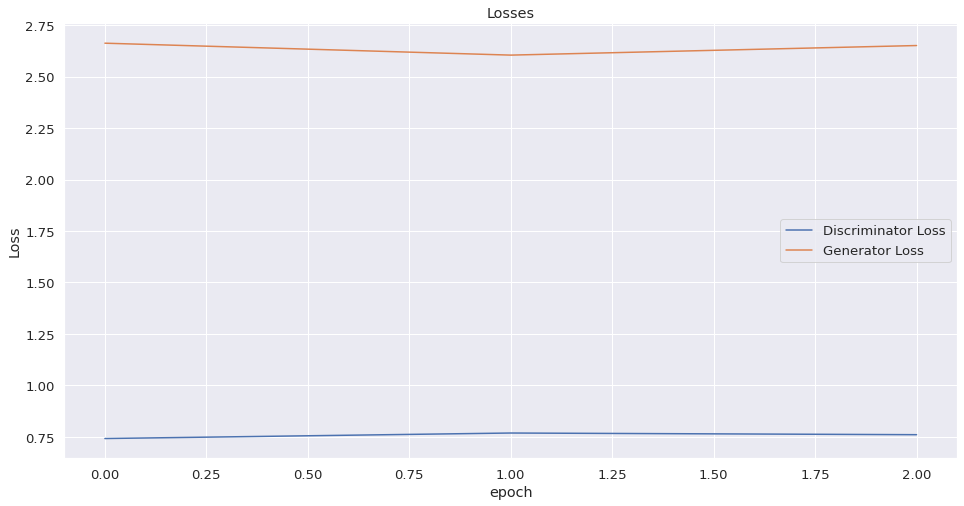

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(losses_d)
plt.plot(losses_g)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

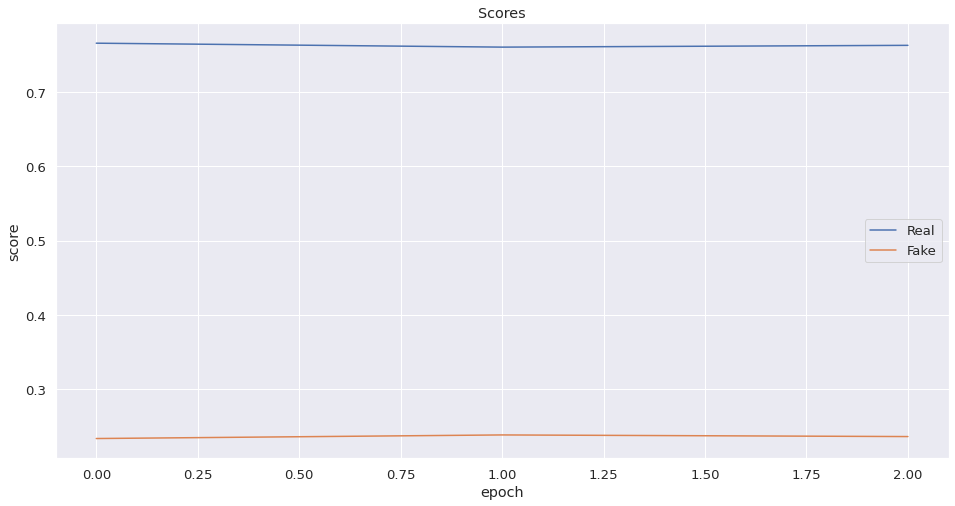

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(real_scores)
plt.plot(fake_scores_1)
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

## Image Generation

In [ ]:
n_images = 64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = Gener(fixed_latent).cpu()

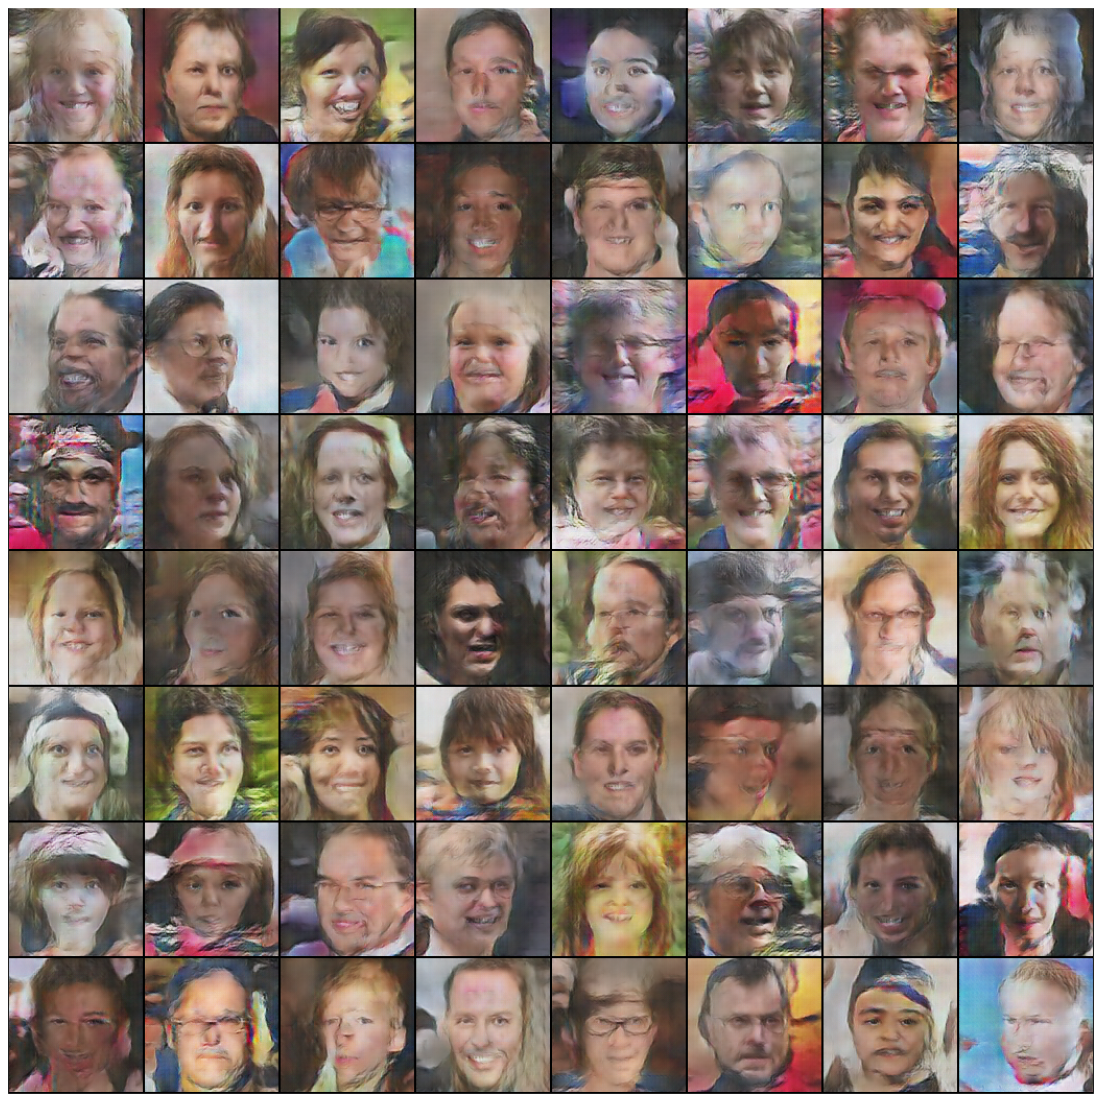

In [ ]:
show_images(fake_images)

### Visualization of distributions

In [ ]:
real = []
gener = []
iter = 0
for X, _ in train_dl:
    fixed_latent = torch.randn(X.shape[0], latent_size, 1, 1, device=device)
    with torch.no_grad():
        fake_images = Gener(fixed_latent).cpu()
        
    for i in range(X.shape[0]):
        real.append(X[i].numpy())
        gener.append(fake_images[i].numpy())

        iter = iter + 1

    if iter > 1000:
        break

real = np.array(real)
gener = np.array(gener)

In [ ]:
real = real.reshape((real.shape[0], 3*128*128))
gener = gener.reshape((gener.shape[0], 3*128*128))

In [ ]:
from sklearn.manifold import TSNE

real_trans = TSNE(n_components=2).fit_transform(real)
gener_trans = TSNE(n_components=2).fit_transform(gener)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


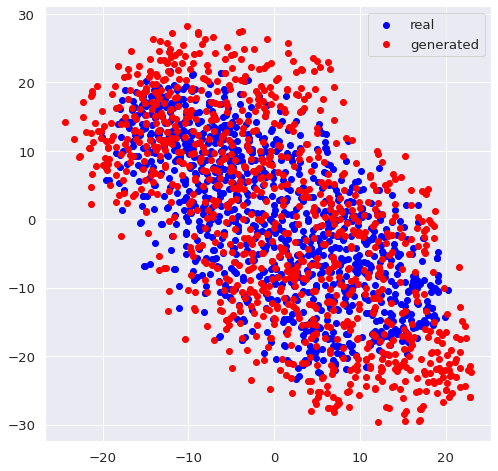

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(real_trans[:, 0], real_trans[:, 1], cmap = 'tab10', color="blue", label="real")
plt.scatter(gener_trans[:, 0], gener_trans[:, 1], cmap = 'tab10', color="red", label="generated")
plt.legend()

We see that the real and generated images are faintly distinguishable from each other.